# Unión de la info de los layouts

In [13]:
import pandas as pd

# Cargar los archivos CSV
df1 = pd.read_csv('layoutsWithTags.csv')
df2 = pd.read_csv('layout_mas.csv', encoding='latin1')


# Fusionar los DataFrames en base a la columna layout_id
merged_df = pd.merge(df1, df2, on='layout_id')


In [15]:
merged_df.to_csv('layouts_todo2.csv', index=False)


In [16]:
print(merged_df.head())

   trial_id  layout_id country_x relevant (new) tags  coincidencia  \
0    9446.0      53750    Brazil           2,4,5,6,8          True   
1    9479.0      53772    Brazil          2,4,5,6,11          True   
2    9692.0      53808       USA                 NaN          True   
3    9692.0      53808       USA            1,3,4,10          True   
4    9672.0      53817       USA                 NaN          True   

              field_name              location country_y  latitude  longitude  \
0              LRV_Milho  State of Mato Grosso    Brasil   -12.680    -56.921   
1   Sertanopolis - Milho       State of Paraná    Brasil   -23.058    -51.039   
2                 CF2225                  Iowa       USA    41.878    -93.097   
3                 CF2225                  Iowa       USA    41.878    -93.097   
4  CF2223_B1_10ft_Normal                  Iowa       USA    41.878    -93.097   

       flight_date  
0  2/24/2022 15:32  
1   4/7/2022 16:11  
2  6/28/2022 13:55  
3  6/28/

# Unión info layouts e info foto

In [19]:
import os
from PIL import Image, ImageStat
import pandas as pd

# Leer el archivo layouts_todo
layouts_todo = pd.read_csv('layouts_todo2.csv')  
directorio = './images'

filas = []

for index, row in layouts_todo.iterrows():
    layout_id = row['layout_id']
    country = row['country_x']
    relevant = row['relevant (new) tags']
    coincidencia = row['coincidencia']
    # Filtro las fotos de ese layout
    imagenes_layout = [filename for filename in os.listdir(directorio) if filename.startswith(str(layout_id) + '_')]
    # Iterar por todas las fotos
    for filename in imagenes_layout:
        # Extraigo características
        img = Image.open(os.path.join(directorio, filename))
        ancho, alto = img.size
        brillo = img.getextrema()[0][0]
        tonalidad = img.getextrema()[1][0]

        # Saturación
        s, _, _ = img.convert('HSV').split()
        estadisticas_saturacion = ImageStat.Stat(s)
        saturacion = estadisticas_saturacion.mean[0]

        # Obtener datos de layouts_todo
        layout_info = layouts_todo[layouts_todo['layout_id'] == layout_id].iloc[0]  # Obtener la primera fila coincidente
        field_name = layout_info['field_name']
        location = layout_info['location']
        latitude = layout_info['latitude']
        longitude = layout_info['longitude']
        flight_date = layout_info['flight_date']

        # Agregar datos
        filas.append({
            'trial_id': row['trial_id'],
            'layout_id': layout_id,
            'country': country,
            'relevant (new) tags': relevant,
            'coincidencia': coincidencia,
            'nombre_imagen': filename,
            'ancho': ancho,
            'alto': alto,
            'brillo': brillo,
            'tonalidad': tonalidad,
            'saturacion': saturacion,
            'field_name': field_name,
            'location': location,
            'latitude': latitude,
            'longitude': longitude,
            'flight_date': flight_date
        })

# Convertir la lista de diccionarios en un DataFrame
nuevo_df2 = pd.DataFrame(filas)


In [29]:
import pandas as pd



nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])

nuevo_df2['year'] = nuevo_df2['flight_date'].dt.year

nuevo_df2['month'] = nuevo_df2['flight_date'].dt.month

paises_unicos = nuevo_df2['country'].unique()

tabla_vuelos = pd.DataFrame()

for pais in paises_unicos:
    df_pais = nuevo_df2[nuevo_df2['country'] == pais]
    vuelos_por_mes = df_pais.groupby(['year', 'month']).size().reset_index(name='count')

    vuelos_por_mes['country'] = pais
    tabla_vuelos = pd.concat([tabla_vuelos, vuelos_por_mes])
tabla_vuelos = tabla_vuelos[['country', 'year', 'month', 'count']]

print(tabla_vuelos)


     country  year  month  count
0     Brazil  2018     10    220
1     Brazil  2018     11    160
2     Brazil  2018     12     60
3     Brazil  2019      1     20
4     Brazil  2019      2    140
5     Brazil  2019      3    160
6     Brazil  2021      4     20
7     Brazil  2022      2     20
8     Brazil  2022      4     20
0        USA  2021      5    100
1        USA  2021      6     40
2        USA  2022      6    680
3        USA  2022      7     40
0  Argentina  2018     11    120
1  Argentina  2019      1     40
2  Argentina  2021      1    160
3  Argentina  2021      2    260


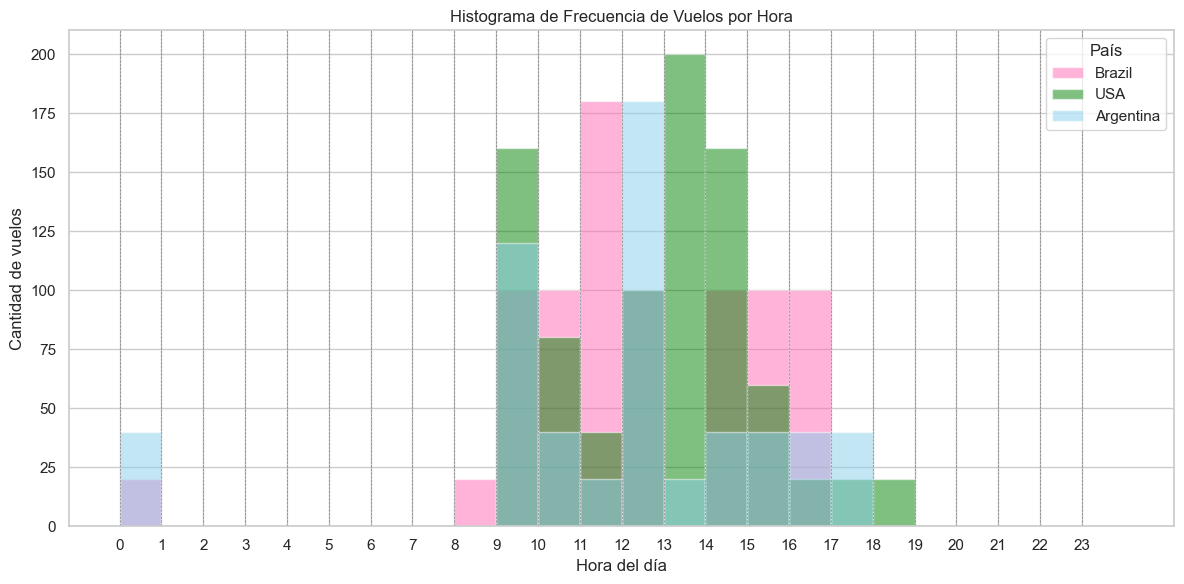

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Establecer el estilo
sns.set(style="whitegrid")

# Obtener la lista de países únicos
paises = nuevo_df2['country'].unique()

# Definir los colores para cada país
colores = {'Brazil': '#FF69B4', 'USA': 'green', 'Argentina': '#87CEEB'}

# Crear el histograma
plt.figure(figsize=(12, 6))
for pais in paises:
    # Filtrar los datos por país
    data_pais = nuevo_df2[nuevo_df2['country'] == pais]
    
    # Obtener la frecuencia de vuelos por hora
    frecuencia_horarios = data_pais['flight_date'].dt.hour
    
    # Configurar el histograma con los mismos intervalos para todos los países
    plt.hist(frecuencia_horarios, bins=range(25), alpha=0.5, label=pais, color=colores.get(pais, 'gray'))

# Configurar el título y etiquetas de los ejes
plt.title('Histograma de Frecuencia de Vuelos por Hora')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de vuelos')
plt.xticks(range(24))
plt.legend(title='País')

# Añadir una línea vertical para cada hora
for hour in range(24):
    plt.axvline(hour, color='gray', linestyle='--', linewidth=0.5)

# Mostrar el gráfico
plt.grid(True)
plt.tight_layout()
plt.show()





## Es bastante similar en todos 
### Rango más común (9;19)

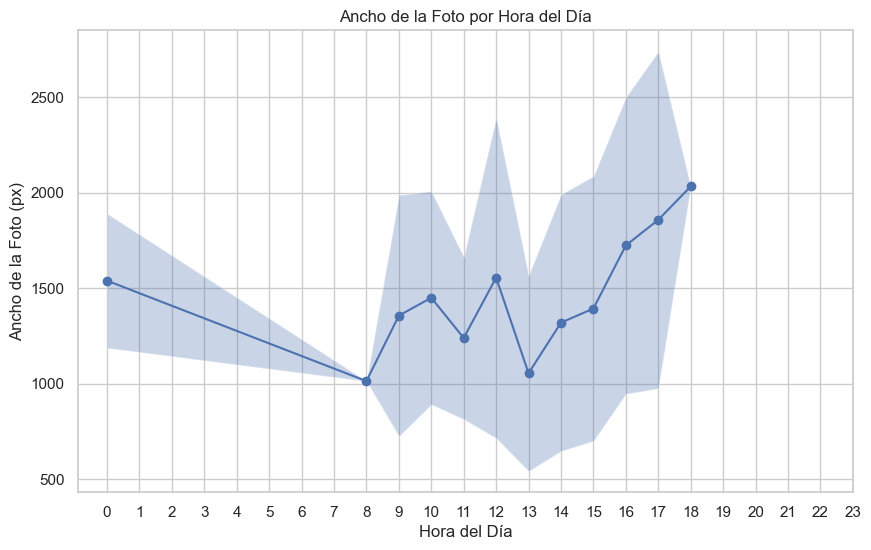

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extraer la hora del día de la columna de fecha
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])
nuevo_df2['hour_of_day'] = nuevo_df2['flight_date'].dt.hour

# 2. Agrupar los datos por hora del día y calcular estadísticas resumidas del ancho de la foto
grupo_por_hora = nuevo_df2.groupby('hour_of_day')['ancho'].describe()

# 3. Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(grupo_por_hora.index, grupo_por_hora['mean'], marker='o', linestyle='-')
plt.fill_between(grupo_por_hora.index, grupo_por_hora['mean'] - grupo_por_hora['std'], grupo_por_hora['mean'] + grupo_por_hora['std'], alpha=0.3)
plt.title('Ancho de la Foto por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Ancho de la Foto (px)')
plt.xticks(range(24))
plt.grid(True)
plt.show()


C:\Users\nicky\AppData\Local\Temp\ipykernel_33560\2561787834.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='ancho', data=nuevo_df2, palette='husl')


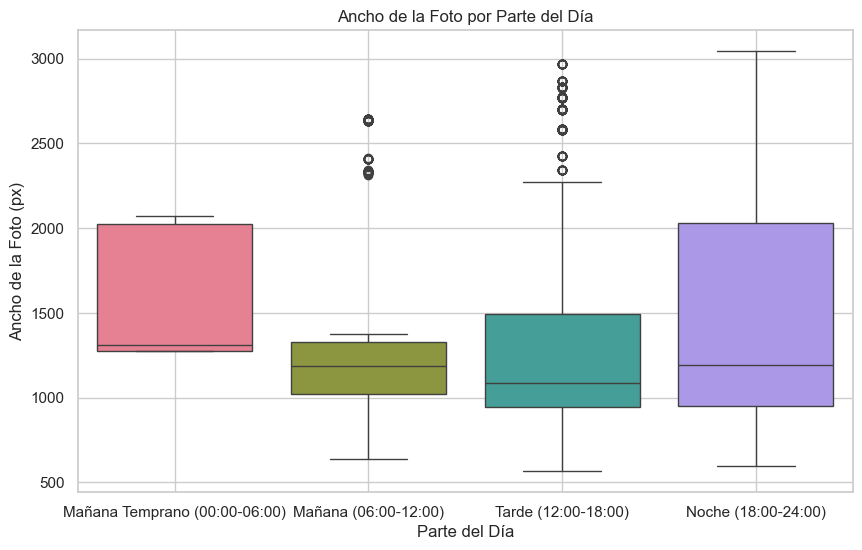

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer la hora del día de la columna de fecha
nuevo_df2['flight_date'] = pd.to_datetime(nuevo_df2['flight_date'])
nuevo_df2['hour_of_day'] = nuevo_df2['flight_date'].dt.hour

# 2. Dividir el día en 4 partes
nuevo_df2['time_of_day'] = pd.cut(nuevo_df2['hour_of_day'], bins=4, labels=['Mañana Temprano (00:00-06:00)', 'Mañana (06:00-12:00)', 'Tarde (12:00-18:00)', 'Noche (18:00-24:00)'])

# 3. Visualizar los resultados usando un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='time_of_day', y='ancho', data=nuevo_df2, palette='husl')
plt.title('Ancho de la Foto por Parte del Día')
plt.xlabel('Parte del Día')
plt.ylabel('Ancho de la Foto (px)')
plt.grid(True)
plt.show()


In [53]:
from scipy.stats import f_oneway

# Realizar el test de ANOVA
resultados_anova = f_oneway(nuevo_df2[nuevo_df2['time_of_day'] == 'Mañana Temprano (00:00-06:00)']['ancho'],
                            nuevo_df2[nuevo_df2['time_of_day'] == 'Mañana (06:00-12:00)']['ancho'],
                            nuevo_df2[nuevo_df2['time_of_day'] == 'Tarde (12:00-18:00)']['ancho'],
                            nuevo_df2[nuevo_df2['time_of_day'] == 'Noche (18:00-24:00)']['ancho'])

# Imprimir los resultados del test de ANOVA
print("Resultados del test ANOVA:")
print("Estadística F:", resultados_anova.statistic)
print("Valor p:", resultados_anova.pvalue)

# Interpretar los resultados
alpha = 0.05
if resultados_anova.pvalue < alpha:
    print("La media del ancho de la foto depende significativamente del horario del día (rechazamos la hipótesis nula).")
else:
    print("No hay suficiente evidencia para concluir que la media del ancho de la foto depende del horario del día (no rechazamos la hipótesis nula).")


Resultados del test ANOVA:
Estadística F: 7.55334391380607
Valor p: 5.0066500815830916e-05
La media del ancho de la foto depende significativamente del horario del día (rechazamos la hipótesis nula).


In [54]:
import ephem

# Función para calcular la estación del año
def calcular_estacion(fecha, latitud, longitud):
    # Crear un objeto de fecha en la ubicación dada
    observador = ephem.Observer()
    observador.date = fecha

    # Coordenadas para el hemisferio norte (latitud positiva)
    observador.lat = latitud
    observador.long = longitud

    # Calcular el sol
    sol = ephem.Sun()
    sol.compute(observador)

    # Determinar la estación del año
    if sol.alt > 0:
        if 80 <= sol.az <= 100:
            estacion = "Primavera"
        elif 350 <= sol.az <= 10:
            estacion = "Verano"
        elif 260 <= sol.az <= 280:
            estacion = "Otoño"
        else:
            estacion = "Invierno"
    else:
        if 260 <= sol.az <= 280:
            estacion = "Primavera"
        elif 170 <= sol.az <= 190:
            estacion = "Verano"
        elif 80 <= sol.az <= 100:
            estacion = "Otoño"
        else:
            estacion = "Invierno"
    
    return estacion

# Agregar el nuevo campo 'estacion_del_ano' a nuevo_df2
nuevo_df2['estacion_del_ano'] = nuevo_df2.apply(lambda row: calcular_estacion(row['flight_date'], row['latitude'], row['longitude']), axis=1)


ModuleNotFoundError: No module named 'ephem'